Кажется тут будет много чего прокомментировать (^ ____ ^)

очень хотел бы послушать критику

Подключаем библеотеки

In [4391]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)

## Предварительная подготовка

Скачаем данные

In [4392]:
# !wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv

Выведем первые 5 строк из датасета

In [4393]:
df = pd.read_csv('house_prices_train.csv')
print(df.columns.shape)
df.head()

(81,)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Выделим колонки, с которыми будем работать

In [4394]:
num_features = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 
                'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
                '1stFlrSF','2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
                'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 
                'GarageCars', 'GarageArea', 'WoodDeckSF','OpenPorchSF', 
                'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
                'MiscVal', 'MoSold', 'YrSold']
len(num_features)

32

Разделим датасет на train и test


In [4395]:
X_train, X_test, y_train, y_test = train_test_split(df[num_features], df['SalePrice'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1168, 32), (292, 32))

## Сделайте стандартизацию/заполните пустые значения/исследуйте на выбросы данные признаков обучающей и тестовой выборки(3 балл)

#### Сначала заполним пустые значения

In [4396]:
result_train = pd.concat([X_train.isnull().sum(), X_train.isnull().mean()], axis=1)
result_train = result_train.rename(index=str,columns={0:'total missing',1:'proportion'})
print(result_train.apply(lambda x: x[x > 0]))

# has_null_val = result.apply(lambda x: x[x > 0]).index
# has_null_val

null_index_for_MasVnrArea_train = X_train[X_train['MasVnrArea'].isnull()].index
null_index_for_MasVnrArea_train.to_numpy()


             total missing  proportion
LotFrontage            217    0.185788
MasVnrArea               6    0.005137
GarageYrBlt             64    0.054795


array([ 936,  973,  650, 1278,  234,  977])

MasVnrArea  можно удалить. 6 примеров на фоне 1400 это мало

In [4397]:
X_train = X_train.dropna(subset=['MasVnrArea'], axis=0, inplace=False)
y_train = y_train.drop(null_index_for_MasVnrArea_train )

X_train.shape, y_train.shape

((1162, 32), (1162,))

GarageYrBlt - год постройки гаража. Значнеие равно None в случае, если гаража нет вприницпе. Это показанно ниже. 


In [4398]:
mask = X_train["GarageYrBlt"].isnull()

subset = ["GarageYrBlt", "GarageArea"]
test = X_train[subset].loc[mask, :]

print(test.shape, test["GarageArea"].sum())
test

(64, 2) 0


,GarageYrBlt,GarageArea
638,NaN,0
210,NaN,0
48,NaN,0
155,NaN,0
1030,NaN,0
...,...,...
520,NaN,0
241,NaN,0
562,NaN,0
1337,NaN,0


Заменим None на год продажи дома и добавим признак наличие или отсутствие гаража

In [4399]:
for i in ["GarageYrBlt"]:
    X_train[i + '_is_NA'] = np.where( X_train[i].isnull(), 0, 1)
X_train["GarageYrBlt"] = X_train["GarageYrBlt"].fillna(value=df['YearBuilt'])
X_train["GarageYrBlt"].shape

(1162,)

LotFrontage - это площадь фасада. Ее можно заменять на медианое значение

In [4400]:
X_train["LotFrontage"] = X_train["LotFrontage"].fillna(X_train["LotFrontage"].mean())

Все тоже самое проделаем с X_test, там точно такие же проблемы

In [4401]:
print(X_test.shape, y_test.shape)
null_index_for_MasVnrArea_test = X_test[X_test['MasVnrArea'].isnull()].index
null_index_for_MasVnrArea_test.to_numpy()
X_test = X_test.dropna(subset=['MasVnrArea'], axis=0, inplace=False)
y_test = y_test.drop(null_index_for_MasVnrArea_test)
for i in ["GarageYrBlt"]:
    X_test[i + '_is_NA'] = np.where( X_test[i].isnull(), 0, 1)
X_test["GarageYrBlt"] = X_test["GarageYrBlt"].fillna(value=df['YearBuilt'])
X_test["LotFrontage"] = X_test["LotFrontage"].fillna(X_test["LotFrontage"].mean())
X_test.shape, y_test.shape


(292, 32) (292,)


((290, 33), (290,))

#### Исследуем на выбросы

Выбросы ищем с помощью IQR метода

In [4402]:
def outlier_detect_IQR(data, col, threshold=3):
    f = False
    # Рассчитываем межквартильный размах (IQR).
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)

    # Вычисляем верхнюю и нижнюю границы для определения выбросов.
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)

    # Формируем кортеж с использованными границами.
    para = (Upper_fence, Lower_fence)

    # Создаем временный DataFrame, в котором для каждой строки указываем, превышает ли значение в столбце заданные границы.
    tmp = pd.concat([data[col] > Upper_fence, data[col] < Lower_fence], axis=1)

    # Находим индексы строк, содержащих хотя бы один выброс.
    outlier_index = tmp.any(axis=1)

    # Выводим информацию о найденных выбросах.
    if len(outlier_index.value_counts()) > 1:
        f = True
        #print(col, end= ": ")
        #print('Найдено выбросов:', outlier_index.value_counts().iloc[1])
    # Возвращаем серию с булевыми значениями и кортеж с границами.
    return outlier_index,f


Удалим те значения, количество которых меньше 55.

In [4403]:
for i in num_features:
    index, find = outlier_detect_IQR(data=X_train, col=i, threshold=3)    
    if find:
        if index.value_counts().iloc[1] < 55:
            X_train = X_train[~index]
            y_train = y_train[~index]
        else:
            print(i, end= ": ")
            print('Найдено выбросов:', index.value_counts().iloc[1])

print(X_train.shape, y_train.shape)

for i in num_features:
    index, find = outlier_detect_IQR(data=X_test, col=i, threshold=3)    
    if find:
        if index.value_counts().iloc[1] < 12:
            X_test = X_test[~index]
            y_test = y_test[~index]
        else:
            print(i, end= ": ")
            print('Найдено выбросов в тест:', index.value_counts().iloc[1])


BsmtHalfBath: Найдено выбросов: 62
EnclosedPorch: Найдено выбросов: 138
ScreenPorch: Найдено выбросов: 88
(967, 33) (967,)
BsmtHalfBath: Найдено выбросов в тест: 15
EnclosedPorch: Найдено выбросов в тест: 40
ScreenPorch: Найдено выбросов в тест: 16


Для отработки разных способов обработки выбрасов, выбросы 62, 88 заполним медианой и модой


Вообще, я понимаю, что оставшиеся выбросы обусловлены тем, что либо нет крыльца, определенного типа, и тогда в таблице ноль, либо оно есть и там стоит площадь крыльца данного типа. Домов, где крыльца нет, сильно больше, чем домов, с крыльцом, поэтому все такие дома воспринимаются как выбросы. Такова природа оставщихся выбросов.

In [4404]:
index1, find = outlier_detect_IQR(data=X_train, col='BsmtHalfBath', threshold=3)
index2, find = outlier_detect_IQR(data=X_train, col='ScreenPorch', threshold=3)

X_train.loc[index1, 'BsmtHalfBath'] = X_train['BsmtHalfBath'].mode()[0]
X_train.loc[index2, 'ScreenPorch'] = X_train['ScreenPorch'].median()
print(X_train.shape, y_train.shape)


index_test_1, find = outlier_detect_IQR(data=X_test, col='BsmtHalfBath', threshold=3)
index_test_2, find = outlier_detect_IQR(data=X_test, col='ScreenPorch', threshold=3)

X_test.loc[index_test_1, 'BsmtHalfBath'] = X_test['BsmtHalfBath'].mode()[0]
X_test.loc[index_test_2, 'ScreenPorch'] = X_test['ScreenPorch'].median()

(967, 33) (967,)


оставим EnclosedPorch без изменения. Посмотрим приведет ли оно к переобучению или нет

#### Проведем нормализацию

нужно отобрать признаки, которые хотим нормализировать. Видимо, все кроме фичей с годами, оценки и  наличие чего-либо

In [4405]:
norm_features = ['MSSubClass', 'LotFrontage', 'LotArea',  'MasVnrArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                'GrLivArea', 'GarageArea', 'WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                'PoolArea', 'MiscVal']


In [4406]:
for feature in norm_features:
    st = StandardScaler().fit(X_train[[feature]])
    X_train[feature] = st.transform(X_train[[feature]])

for feature in norm_features:
    st = StandardScaler().fit(X_test[[feature]])
    X_test[feature] = st.transform(X_test[[feature]])

## Воспользоваться методом OLS библиотеки statsmodels для рассчета коэфициентов линейной регрессии (1 балл)

In [4407]:
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     225.5
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        02:33:17   Log-Likelihood:                -11225.
No. Observations:                 967   AIC:                         2.250e+04
Df Residuals:                     941   BIC:                         2.263e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
MSSubClass        -4478.4003   1172.822     -3.818      0.000   -6780.049   -2176.751
LotFrontage        1602.3845   1189.686      1.347      0.178    -732.361    3937.130
LotArea            3185.1635   1254.187      2.540      0.011     723.837    5646.490
OverallQual        1.608e+04   1123.324     14.317      0.000    1.39e+04    1.83e+04
OverallCond        4366.8956   1013.762      4.308      0.000    2377.400    6356.391
YearBuilt           437.0518     77.864      5.613      0.000     284.245     589.858
YearRemodAdd        123.5801     65.768      1.879      0.061      -5.489     252.649
MasVnrArea         1752.9616   1008.147      1.739      0.082    -225.516    3731.439
1stFlrSF           1.193e+04   1053.296     11.327      0.000    9863.408     1.4e+04
2ndFlrSF           7580.5793   1139.752      6.651      0.000    5343.830    9817.328
LowQualFinSF       1.325e-07   2.03e-07      0.652      0.515   -2.66e-07    5.31e-07
GrLivArea          1.598e+04   1248.793     12.799      0.000    1.35e+04    1.84e+04
BsmtFullBath       1.453e+04   1892.276      7.678      0.000    1.08e+04    1.82e+04
BsmtHalfBath      -5.609e-08    8.6e-08     -0.652      0.514   -2.25e-07    1.13e-07
FullBath          -2637.1927   2783.218     -0.948      0.344   -8099.226    2824.841
HalfBath          -1295.3941   2618.659     -0.495      0.621   -6434.481    3843.693
BedroomAbvGr      -1.132e+04   1815.310     -6.236      0.000   -1.49e+04   -7758.348
KitchenAbvGr      -8.902e+05   1.37e+06     -0.652      0.515   -3.57e+06    1.79e+06
TotRmsAbvGrd       4783.1207   1229.756      3.889      0.000    2369.739    7196.503
Fireplaces         3245.1695   1707.403      1.901      0.058    -105.589    6595.928
GarageYrBlt         -64.6016     80.702     -0.800      0.424    -222.979      93.776
GarageCars         6033.8023   2965.042      2.035      0.042     214.942    1.19e+04
GarageArea         7079.4438   2054.231      3.446      0.001    3048.040    1.11e+04
WoodDeckSF         1113.5814    950.903      1.171      0.242    -752.555    2979.718
OpenPorchSF        1562.0099    970.474      1.610      0.108    -342.534    3466.554
EnclosedPorch        52.5058    988.912      0.053      0.958   -1888.223    1993.234
3SsnPorch                  0          0        nan        nan           0           0
ScreenPorch                0          0        nan        nan           0           0
PoolArea                   0          0        nan        nan           0           0
MiscVal                    0          0        nan        nan           0           0
MoSold             -102.2805    334.154     -0.306      0.760    -758.053     553.492
YrSold              -13.0975    677.149     -0.019      0.985   -1341.994    1315.799
GarageYrBlt_is_NA -2.045e+04   5208.553     -3.925      0.000   -3.07e+04

## Выберите переменные, которые статистически положительно связаны с ценой на дом. (1 балл) 

C ценой на дом статистически положительно связаны переменные с положиельными коэффициентами. Среди таких отберем те, у которых p-value < 0.05

LotArea, OverallQual, OverallCond, YearBuilt, 1stFlrSF, 2ndFlrSF, GrLivArea, BsmtFullBath, TotRmsAbvGrd, GarageCars, GarageArea

## Оцените модель на тестовом сете - метрики $R^2$ и RMSE. Что мы можем сказать по ошибке? (1 балл)

In [4408]:
from sklearn.metrics import mean_squared_error
from math import sqrt
model.params
pred = X_test @ model.params
print("RMSE: ", sqrt(mean_squared_error(y_train, model.predict())))
# R-squared можно взять из таблицы
print("R-squared: ", model.rsquared)

RMSE:  26599.003866065108
R-squared:  0.8569705962063477


Кажется, RMSE довольно плохой, а R-squared хороший получился.

кажется, можно сделать вывод о том, что есть корреляция в дизайн-матрице, посколько R получился хорошим, а RMSE не хорошим :(

## Придумайте какой-нибудь хороший новый признак. Смогли ли вы снизить ошибку на обучении за счет него? (0.5 балла)

## В нашей модели много признаков. Возможно ли нам уменьшить количеcтво признаков, при этом сохранив качество модели? (0.5 балла)

Да, можно убрать те, которые дают нулевые коэффицинеты, а так же, если два признака имеют большую корреляцию, можно удалить один из них. Большая корреляцию у некоторых признаков есть. Это можно увидеть ниже

/Users/moisha/miniconda3/envs/ml_env/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

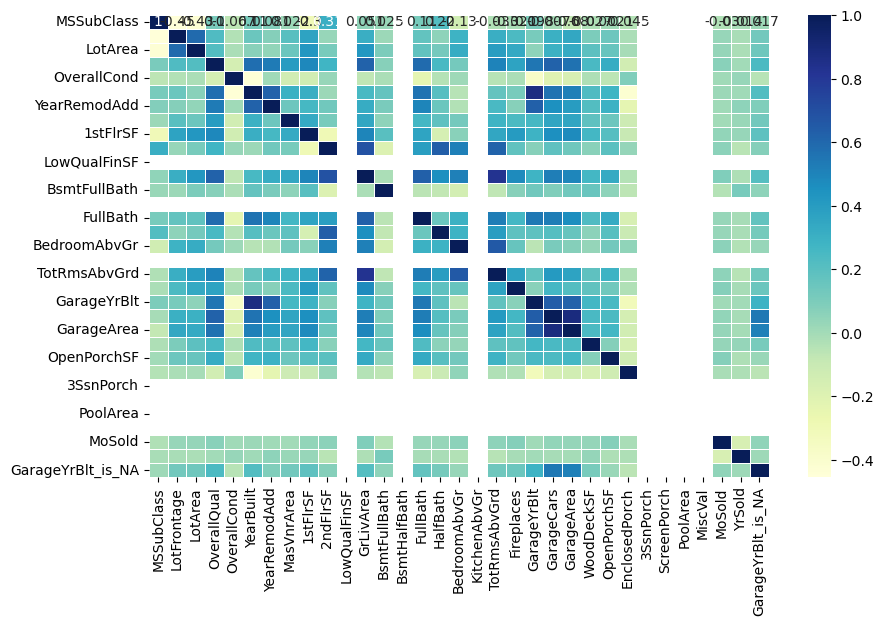

In [4409]:
corrmat = X_train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.heatmap(corrmat, cmap="YlGnBu", linewidths=.5, annot=True)